In [21]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

In [22]:
# Loading the data from the pre-processing part
clean_data = np.load('../dataset/clean_data.npy')

In [23]:
bigrams = [(int(clean_data[k][5][m][0]), int(clean_data[k][5][m+1][0])) for k in range(890) for m in range(clean_data[k][5].shape[0] - 1) ]

trigrams = [(int(clean_data[k][5][m][0]), int(clean_data[k][5][m+1][0]), int(clean_data[k][5][m+2][0])) \
            for k in range(890) for m in range(clean_data[k][5].shape[0] - 2) ]

fourgrams = [(int(clean_data[k][5][m][0]), int(clean_data[k][5][m+1][0]), int(clean_data[k][5][m+2][0]), \
              int(clean_data[k][5][m+3][0])) for k in range(890) for m in range(clean_data[k][5].shape[0] - 3) ]

In [24]:
c_bi = Counter(bigrams)
len(c_bi.most_common(20))

20

In [25]:
def plot_bigrams(big, n):
    c_bi = Counter(big)

    mc_bigrams = [c_bi.most_common(n)[k][0] for k in range(n)]
    mc_bigrams_counts = [c_bi.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_bigrams_counts)
    plt.xticks(np.arange(n), mc_bigrams)
    plt.xlabel('Bigram of chords')
    plt.ylabel('Number of those bigrams in songs')
    plt.title('Most used bigram of chords')
    plt.show()

In [26]:
def plot_trigrams(trig, n):
    c_tri = Counter(trig)

    mc_trigrams = [c_tri.most_common(n)[k][0] for k in range(n)]
    mc_trigrams_counts = [c_tri.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_trigrams_counts)
    plt.xticks(np.arange(n), mc_trigrams)
    plt.xlabel('Trigram of chords')
    plt.ylabel('Number of those trigrams in songs')
    plt.title('Most used trigram of chords')
    plt.show()

In [27]:
def plot_fourgrams(fourg, n):
    c_four = Counter(fourg)

    mc_fourgrams = [c_four.most_common(n)[k][0] for k in range(n)]
    mc_fourgrams_counts = [c_four.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_fourgrams_counts)
    plt.xticks(np.arange(n), mc_fourgrams)
    plt.xlabel('Fourgram of chords')
    plt.ylabel('Number of those fourgrams in songs')
    plt.title('Most used fourgram of chords')
    plt.show()

In [28]:
plot_fourgrams(fourgrams, 10)

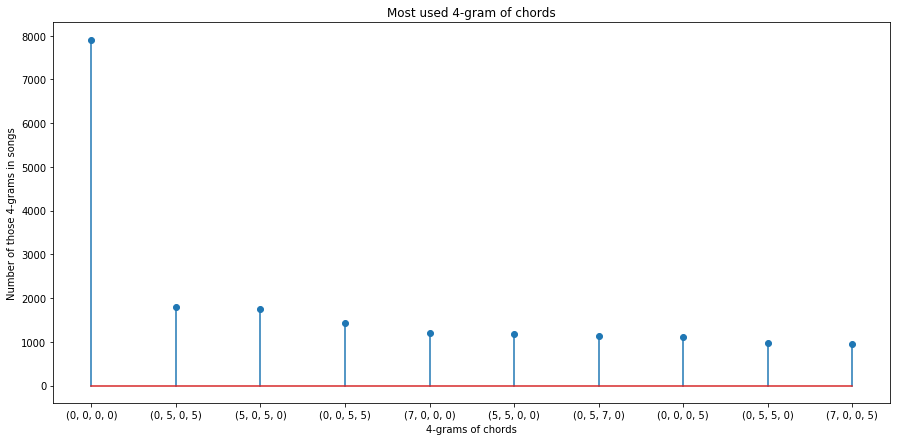

[(9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 5),
 (0, 0, 5, 5),
 (0, 5, 5, 2),
 (5, 5, 2, 2),
 (5, 2, 2, 7),
 (2, 2, 7, 7),
 (2, 7, 7, 0),
 (7, 7, 0, 0),
 (7, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 5),
 (0, 0, 5, 5),
 (0, 5, 5, 2),
 (5, 5, 2, 2),
 (5, 2, 2, 7),
 (2, 2, 7, 7),
 (2, 7, 7, 0),
 (7, 7, 0, 0),
 (7, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 5),
 (0, 0, 5, 5),
 (0, 5, 5, 2),
 (5, 5, 2, 2),
 (5, 2, 2, 7),
 (2, 2, 7, 7),
 (2, 7, 7, 0),
 (7, 7, 0, 0),
 (7, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 9),
 (0, 0, 9, 9),
 (0, 9, 9, 0),
 (9, 9, 0, 0),
 (9, 0, 0, 5),
 (0, 0, 5,

In [40]:
# General function for computing and plotting n-grams

def plot_n_grams(clean_data, ng, n):
    """
    This function computes and plots the n-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    """
    
    ngrams = []
    
    for k in range(890):
        for m in range(clean_data[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([int(clean_data[k][5][m+o][0]) for o in range(ng)]))          

    c_gram = Counter(ngrams)

    mc_grams = [c_gram.most_common(n)[k][0] for k in range(n)]
    mc_grams_counts = [c_gram.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_grams_counts)
    plt.xticks(np.arange(n), mc_grams)
    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs'.format(ng))
    plt.title('Most used {}-gram of chords'.format(ng))
    plt.show()
    
    return ngrams
    
    
plot_n_grams(clean_data, 4, 10)

In [39]:
ngrams

NameError: name 'ngrams' is not defined

In [30]:
diff_bigrams = [int(clean_data[k][5][m+1][0]) - int(clean_data[k][5][m][0]) for k in range(890) for m in range(clean_data[k][5].shape[0] - 1) ]

In [31]:
# General function for computing and plotting n-differences

def plot_diff_grams(clean_data, ng, n):
    """
    This function computes and plots the diff-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    """
    
    diffgrams = []
    
    for k in range(890):
        for m in range(clean_data[k][5].shape[0] - ng+1):
            diffgrams.append(tuple([int(clean_data[k][5][m+o+1][0]) - int(clean_data[k][5][m+o][0]) for o in range(ng-1)]))          

    c_gram = Counter(diffgrams)

    mc_dgrams = [c_gram.most_common(n)[k][0] for k in range(n)]
    mc_dgrams_counts = [c_gram.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_dgrams_counts)
    plt.xticks(np.arange(n), mc_dgrams)
    plt.xlabel('{}-difference of chords'.format(ng-1))
    plt.ylabel('Number of those {}-difference in songs'.format(ng-1))
    plt.title('Most used {}-difference of chords in semitones'.format(ng-1))
    plt.show()
    
    
plot_diff_grams(clean_data, 4, 15)

In [32]:
# General function for computing and plotting n-grams with modes

def plot_full_n_grams(clean_data, ng, n):
    """
    This function computes and plots the n-grams of our clean data with chord modes.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    """
    
    ngrams = []
    
    for k in range(890):
        for m in range(clean_data[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([(int(clean_data[k][5][m+o][0]), clean_data[k][5][m+o][1]) for o in range(ng)]))          

    c_gram = Counter(ngrams)
    
    mc_grams = [c_gram.most_common(n)[k][0] for k in range(n)]
    # for k in range(n):
      #   mc_grams.append(tuple([str(c_gram.most_common(n)[k][m][0][0])+', '+c_gram.most_common(n)[k][m][0][1] for m in range(ng)]))
    
    mc_grams_counts = [c_gram.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_grams_counts)
    plt.xticks(np.arange(n), mc_grams)
    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs'.format(ng))
    plt.title('Most used full {}-gram of chords'.format(ng))
    plt.show()
    
    
plot_full_n_grams(clean_data, 2, 7)

# Evolution of popularity of (0,5) bigram over time

In [95]:
from datetime import datetime
year2fourgrams = dict()
ng=2

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year2fourgrams[year]=list()
    
for elem in clean_data: # populate for real
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    
    for m in range(elem[5].shape[0] - ng + 1):
        year2fourgrams[year].append(tuple([int(elem[5][m+o][0]) for o in range(ng)]))

In [97]:
year2chord05 = dict()

for year in year2fourgrams:
    year2chord05[year] = year2fourgrams[year].count(tuple((0,5))) / len(year2fourgrams[year])
    
year2chord05[year]

0.06836363636363636

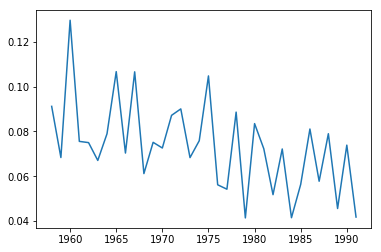

In [99]:
lists = sorted(year2chord05.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()